# Assignment 2

In [ ]:
# =================================================================================================
# Authors: Andrei Landayan Angeles (), Chathu Siriwardena (), Mark Sturtz (218306846)
# Description: Code document for group assessment task 2.
# =================================================================================================
# Version     |    Date      |    Author        |  Updates
# 0.1         |  23-Aug-2024 |    Andrei        |  Initial Version - Creating Git Repo
# 0.2         |  25-Aug-2024 |    Mark          |  Minor changes to log, add library imports & load data in spark df
# 0.3         |  30-Aug-2024 |    Mark          |  Directly read data using spark
# 0.4         |  31-Aug-2024 |    Chathu        |  Answer 1.6
# 0.5         |  31-Aug-2024 |    Chathu        |  Answer 1.7

#### Library Imports

In [34]:
import pandas as pd
import os
from pyspark.sql import SparkSession
from pyspark.sql.functions import regexp_replace, col, when, translate, sum, month, date_format, countDistinct, collect_list
import matplotlib.pyplot as plt
import numpy as np
from pyspark.sql.functions import udf, size, concat_ws, lit, col
from pyspark.sql.types import ArrayType, StringType

In [7]:
# Initialize Spark session
spark = SparkSession.builder.appName("SIT742Task2").getOrCreate()

#### Load Data

In [35]:
# define external path with getcwd()
external_path = os.getcwd()

# define path do data
data_path = external_path+'/data/transactionrecord'

# create spark df
df = spark.read.format("csv").options(header='true', inferSchema='true', delimiter=',').load(data_path)

# display the first 5 rows
df.show(n=5)

+-------------+---------+---------+--------------------+----------------+-----+--------+----------+--------------+
|TransactionNo|     Date|ProductNo|         ProductName|Product_category|Price|Quantity|CustomerNo|       Country|
+-------------+---------+---------+--------------------+----------------+-----+--------+----------+--------------+
|       581482|12/9/2019|    22485|Set Of 2 Wooden M...|             0ca|21.47|      12|     17490|United Kingdom|
|       581475|12/9/2019|    22596|Christmas Star Wi...|             0ca|10.65|      36|     13069|United Kingdom|
|       581475|12/9/2019|    23235|Storage Tin Vinta...|             0ca|11.53|      12|     13069|United Kingdom|
|       581475|12/9/2019|    23272|Tree T-Light Hold...|             0ca|10.65|      12|     13069|United Kingdom|
|       581475|12/9/2019|    23239|Set Of 4 Knick Kn...|             0ca|11.94|       6|     13069|United Kingdom|
+-------------+---------+---------+--------------------+----------------+-----+-

## Part 1

##### Answer 1.1

In [36]:
#1.1.1
# Looks and replaces 'NA' in CustomerNo column with '-1'
df = df.withColumn("CustomerNo", when(col("CustomerNo") == "NA", "-1").otherwise(col("CustomerNo")))

#1.1.2
# Processes the productName column to only have alphabet characters
df = df.withColumn("productName_process", translate(col("ProductName"), "0123456789", ""))

# Displays the first five rows of the transactionrecord
df.show(5)


+-------------+---------+---------+--------------------+----------------+-----+--------+----------+--------------+--------------------+
|TransactionNo|     Date|ProductNo|         ProductName|Product_category|Price|Quantity|CustomerNo|       Country| productName_process|
+-------------+---------+---------+--------------------+----------------+-----+--------+----------+--------------+--------------------+
|       581482|12/9/2019|    22485|Set Of 2 Wooden M...|             0ca|21.47|      12|     17490|United Kingdom|Set Of  Wooden Ma...|
|       581475|12/9/2019|    22596|Christmas Star Wi...|             0ca|10.65|      36|     13069|United Kingdom|Christmas Star Wi...|
|       581475|12/9/2019|    23235|Storage Tin Vinta...|             0ca|11.53|      12|     13069|United Kingdom|Storage Tin Vinta...|
|       581475|12/9/2019|    23272|Tree T-Light Hold...|             0ca|10.65|      12|     13069|United Kingdom|Tree T-Light Hold...|
|       581475|12/9/2019|    23239|Set Of 4 Knic

##### Answer 1.2

+-------------+---------+---------+--------------------+----------------+-----+--------+----------+--------------+--------------------+-------+
|TransactionNo|     Date|ProductNo|         ProductName|Product_category|Price|Quantity|CustomerNo|       Country| productName_process|Revenue|
+-------------+---------+---------+--------------------+----------------+-----+--------+----------+--------------+--------------------+-------+
|       581482|12/9/2019|    22485|Set Of 2 Wooden M...|             0ca|21.47|      12|     17490|United Kingdom|Set Of  Wooden Ma...| 257.64|
|       581475|12/9/2019|    22596|Christmas Star Wi...|             0ca|10.65|      36|     13069|United Kingdom|Christmas Star Wi...|  383.4|
|       581475|12/9/2019|    23235|Storage Tin Vinta...|             0ca|11.53|      12|     13069|United Kingdom|Storage Tin Vinta...| 138.36|
|       581475|12/9/2019|    23272|Tree T-Light Hold...|             0ca|10.65|      12|     13069|United Kingdom|Tree T-Light Hold...| 

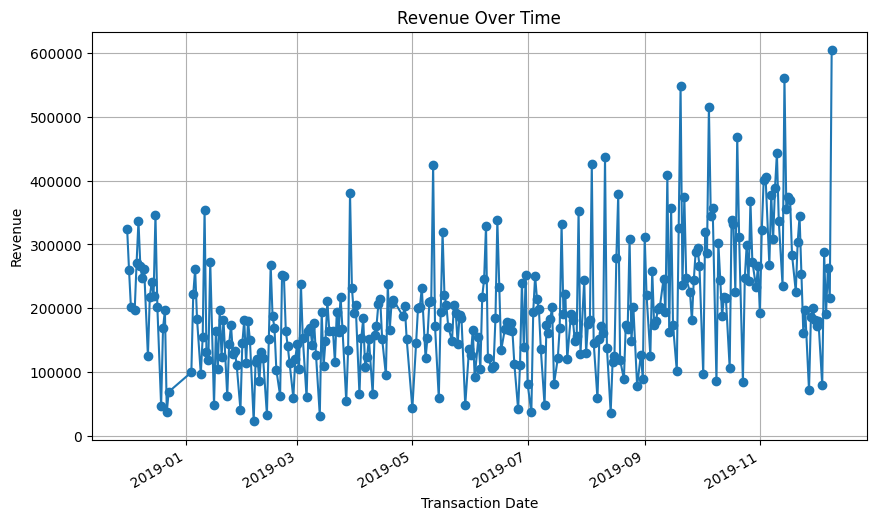

In [37]:
#1.2.1
# Calculates the revenue and displays the first 5 rows.
df = df.withColumn("Revenue", (col("Price") * col("Quantity")).cast("float"))
df.show(5)

#1.2.2
# Converts to pandas, and creates a transaction_date, and shows first 5 rows.
df_pandas = df.toPandas()
df_pandas['transaction_date'] = pd.to_datetime(df_pandas['Date'], format="%m/%d/%Y")
print(df_pandas.head(5))

#1.2.3
# Plots the revenue over time
df_grouped = df_pandas.groupby('transaction_date')['Revenue'].sum()
df_grouped.plot(title='Revenue Over Time', xlabel='Transaction Date', ylabel='Revenue', figsize=(10, 6), marker='o')
plt.grid(True)
plt.show()


##### Answer 1.3

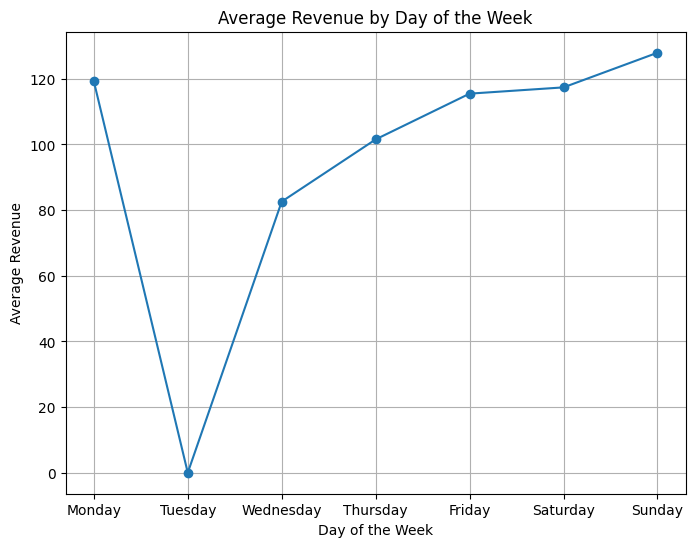

The workday with the highest average revenue is: Sunday


In [38]:
# 1.3.1
#Extract the day of the week from transaction_date
df_pandas['day_of_week'] = df_pandas['transaction_date'].dt.day_name()

# Average revenue by day of the week


average_revenue_by_day = df_pandas.groupby('day_of_week')['Revenue'].mean()

# Plot of average revenue by day of the week
average_revenue_by_day = average_revenue_by_day.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']).replace(np.nan, 0)
average_revenue_by_day.plot(title='Average Revenue by Day of the Week', xlabel='Day of the Week', ylabel='Average Revenue', figsize=(8, 6), marker='o')
plt.grid(True)
plt.show()

# Workday with the highest average revenue
highest_revenue_day = average_revenue_by_day.idxmax()
print(f"The workday with the highest average revenue is: {highest_revenue_day}")



In [39]:
# 1.3.2 Filter the DataFrame for the top workday
df_top_workday = df_pandas[df_pandas['day_of_week'] == highest_revenue_day]

# The product with the highest revenue on that workday
top_product_by_revenue = df_top_workday.groupby('productName_process')['Revenue'].sum().idxmax()
print(f"The product with the highest revenue on {highest_revenue_day} is: {top_product_by_revenue}")

# The product with the highest sales volume on that workday
top_product_by_volume = df_top_workday.groupby('productName_process')['Quantity'].sum().idxmax()
print(f"The product with the highest sales volume on {highest_revenue_day} is: {top_product_by_volume}")


The product with the highest revenue on Sunday is: World War  Gliders Asstd Designs
The product with the highest sales volume on Sunday is: World War  Gliders Asstd Designs


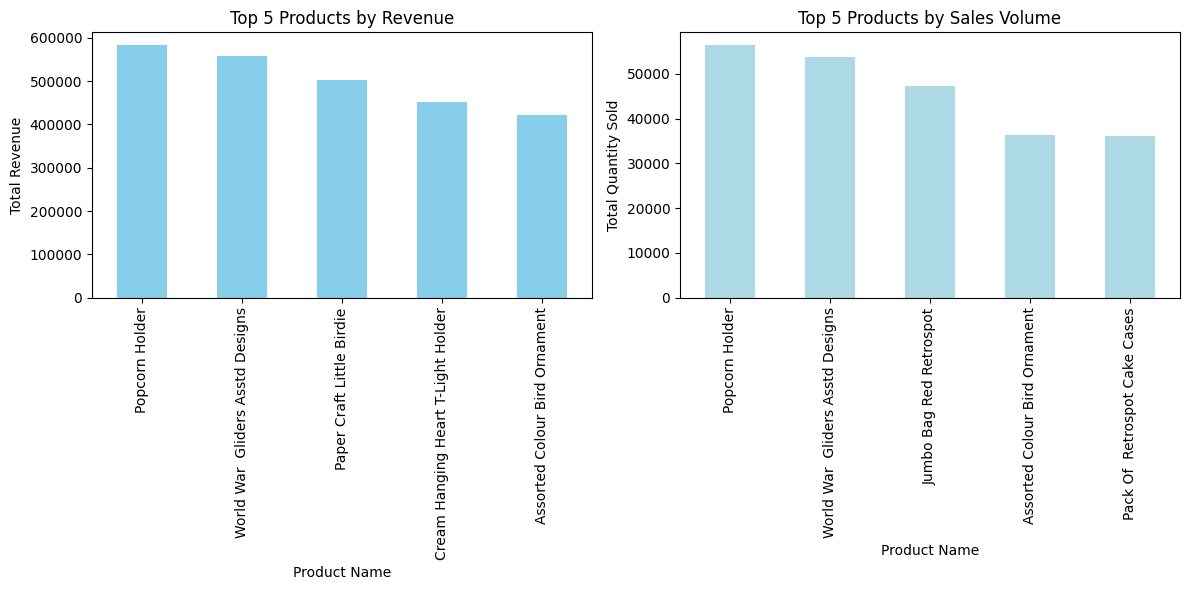

In [40]:
# 1.3.3 Find the top 5 products by revenue in general

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Top 5 products by revenue in general
top_5_products_by_revenue = df_pandas.groupby('productName_process')['Revenue'].sum().nlargest(5)

# Plot the top 5 products by revenue
top_5_products_by_revenue.plot(kind='bar', ax=axes[0], color='skyblue')
axes[0].set_title('Top 5 Products by Revenue')
axes[0].set_xlabel('Product Name')
axes[0].set_ylabel('Total Revenue')

# Top 5 products by sales volume in general
top_5_products_by_volume = df_pandas.groupby('productName_process')['Quantity'].sum().nlargest(5)

# Plot the top 5 products by sales volume
top_5_products_by_volume.plot(kind='bar', ax=axes[1], color='lightblue')
axes[1].set_title('Top 5 Products by Sales Volume')
axes[1].set_xlabel('Product Name')
axes[1].set_ylabel('Total Quantity Sold')

plt.tight_layout()

# Display the plots
plt.show()



##### Answer 1.4

In [ ]:
# 1.4.1
# Calc our total rev per country
country_rev = df_filtered.groupBy("Country").agg(sum("Revenue").alias("TotalRevenue"))

# 1.4.2
# Show the country with the highest revenue
best_country = country_rev.orderBy(col("TotalRevenue").desc()).first()["Country"]
print(f"The country with the highest revenue is: {best_country}")

# 1.4.3
# Calc monthly rev for the best country and thier highest revenue
monthly_rev = df_filtered.filter(col("Country") == best_country).groupBy(date_format(col("Date"), "MMMM").alias("Best Month")).agg(sum("Revenue").alias("Monthly Revenue")).orderBy(col("Monthly Revenue").desc())

# 1.4
# Show the highest rev
monthly_rev.show(1, truncate=False)


24/08/29 05:02:07 WARN TaskSetManager: Stage 176 contains a task of very large size (7465 KiB). The maximum recommended task size is 1000 KiB.


The country with the highest revenue is: United Kingdom


24/08/29 05:02:11 WARN TaskSetManager: Stage 179 contains a task of very large size (7465 KiB). The maximum recommended task size is 1000 KiB.


+----------+------------------+
|Best Month|Monthly Revenue   |
+----------+------------------+
|July      |2224407.9053735733|
+----------+------------------+
only showing top 1 row



#### Answer 1.5

In [41]:


# 1.5.1
# Filter out transc with quantity <= 0
valid_transactions = df.filter(col("Quantity") > 0)

# 1.5.2
# Find shopping frequency by counting the distinct transc per customer
customer_freq = valid_transactions.groupBy("CustomerNo").agg(countDistinct("TransactionNo").alias("ShoppingFrequency"))

# 1.5.3
# Find the customer with the highest shopping frequency
most_frequent_customer = customer_freq.orderBy(col("ShoppingFrequency").desc()).first()["CustomerNo"]
print(f"The customer who shops most frequently is: {most_frequent_customer}")

# 1.5.4
# Find the products based on the most freq customer and the products
customer_products = valid_transactions.filter(col("CustomerNo") == most_frequent_customer).groupBy("productName_process").agg(sum("Quantity").alias("TotalQuantity")).orderBy(col("TotalQuantity").desc())

# 1.5
# Show the products and quantity
customer_products.show(truncate=False)


The customer who shops most frequently is: 12748
+-----------------------------------+-------------+
|productName_process                |TotalQuantity|
+-----------------------------------+-------------+
|Victorian Metal Postcard Spring    |595          |
|World War  Gliders Asstd Designs   |480          |
|Rose Scent Candle Jewelled Drawer  |408          |
|Cartoon Pencil Sharpeners          |405          |
|Small White Retrospot Mug In Box   |390          |
|Vanilla Scent Candle Jewelled Box  |380          |
|Small Red Retrospot Mug In Box     |372          |
|Bubblegum Ring Assorted            |318          |
|Popart Wooden Pencils Asst         |300          |
|Ocean Scent Candle In Jewelled Box |225          |
|Pens Assorted Funny Face           |216          |
|Assorted Creepy Crawlies           |216          |
|Garage Key Fob                     |174          |
|Marie Antoinette Trinket Box Silver|168          |
|Key Fob Shed                       |164          |
|Brocade Ring P

#### Answer 1.6

In [58]:
# 1.6.1
#Group by the transactionNo and aggregate the category of product

df_basket = valid_transactions.groupBy("TransactionNo").agg(
    collect_list("product_category").alias("ProductCategoryList"),
    collect_list("productName_process").alias("ProductNameList")
)

df_basket.show(10,truncate=False)

# 1.6.2
# Define a Function to remove duplicates
def remove_adjacent_duplicates(lst):
    if lst is None:
        return []
    return [x for i, x in enumerate(lst) if i == 0 or x != lst[i - 1]]

# Convert the function to PySpark UDF
remove_adjacent_duplicates_udf = udf(remove_adjacent_duplicates, ArrayType(StringType()))

# Apply the UDF
df_1 = df_basket.withColumn("productCategoryList", remove_adjacent_duplicates_udf(col("productCategoryList")))

#Show the df_1
df_1.show(10, truncate=False)



+-------------+--------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|TransactionNo|ProductCategoryList                                                             |ProductNameList                                                                                                                                                                                                                                                                                                  

#### Answer 1.7

In [68]:
#1.7.1
# Create the 'prod_len' column
df_1 = df_1.withColumn("prod_len", size("productCategoryList"))

# Show the first 5 rows
df_1.select("TransactionNo", "productCategoryList", "prod_len").show(5, truncate=False)

#1.7.2
# Define a Function to transform the list into the path format
def transform_to_path(categories):
    return "start > " + " > ".join(categories) + " > conversion"

transform_to_path_udf = udf(transform_to_path, StringType())

# Apply the transformation
df_1 = df_1.withColumn("path", transform_to_path_udf("productCategoryList"))

# Show the first 10 rows
df_1.select("TransactionNo", "productCategoryList", "prod_len", "path").show(10, truncate=False)

def data_processing(df, maxlength=3, minlength=1):
    # Filter based on prod_len
    filtered_df = df.filter((col("prod_len") <= maxlength) & (col("prod_len") >= minlength))

    # Transform the list into the required path format
    df_2 = filtered_df.withColumn("path", transform_to_path_udf("productCategoryList"))
    return df_2

# Apply the function with maxlength=5, minlength=2
df_2 = data_processing(df_1, maxlength=5, minlength=2)

# Show the top 10 rows
df_2.select("TransactionNo", "productCategoryList", "prod_len", "path").show(10, truncate=False)



+-------------+-------------------+--------+
|TransactionNo|productCategoryList|prod_len|
+-------------+-------------------+--------+
|536365       |[0ca]              |1       |
|536366       |[0ca]              |1       |
|536367       |[0ca]              |1       |
|536368       |[0ca]              |1       |
|536369       |[0ca]              |1       |
+-------------+-------------------+--------+
only showing top 5 rows

+-------------+-------------------+--------+------------------------+
|TransactionNo|productCategoryList|prod_len|path                    |
+-------------+-------------------+--------+------------------------+
|536365       |[0ca]              |1       |start > 0ca > conversion|
|536366       |[0ca]              |1       |start > 0ca > conversion|
|536367       |[0ca]              |1       |start > 0ca > conversion|
|536368       |[0ca]              |1       |start > 0ca > conversion|
|536369       |[0ca]              |1       |start > 0ca > conversion|
|536370   

## Part 2

##### Answer 2.1